In [321]:
# from scipy.stats import entropy
from scipy.stats.mstats import zscore
from scipy.stats import entropy 
import matplotlib.pyplot as plt
import seaborn as sns

from __init__ import *
from snmcseq_utils import create_logger
from snmcseq_utils import tsne_and_boxplot 
from CEMBA_update_mysql import connect_sql
from CEMBA_update_mysql import gene_id_to_table_name
from CEMBA_init_ensemble_v2 import pull_genebody_info 

In [322]:
# import importlib
# import snmcseq_utils
# importlib.reload(snmcseq_utils)
# from snmcseq_utils import tsne_and_boxplot 


In [323]:
def get_cluster_mc_c_worker(df_cells, df_input, cluster_col):
    """reduce gene*cell or bin*cell matrix to a gene*cluster or bin*cluster matrix
    Arguments:
        - df_cells: a dataframe indexed by 'cell_name', and have '$cluster_col' as column
        - df_input: a dataframe with 'sample_mc', 'sample_c' ... as columns
        sample names are cell names
    """
    # cluster mc_c
    df_c = df_input.filter(regex='_c$')
    df_mc = df_input.filter(regex='_mc$')

    df_mc_c = pd.DataFrame() 
    for label, df_sub in df_cells.groupby(cluster_col):
        samples = df_sub.index.values
        df_mc_c['{}_mc'.format(label)] = df_mc[samples+'_mc'].sum(axis=1)
        df_mc_c['{}_c'.format(label)] = df_c[samples+'_c'].sum(axis=1)

    logging.info("Output shape: {}".format(df_mc_c.shape))
    return df_mc_c

In [324]:
def get_mcc(df, base_call_cutoff=100, sufficient_coverage_fraction=1, suffix=True):
    """Get mcc matrix from mc_c matrix (filtering out low coverage gene or bins)
    """
    logging.info('Getting mcc matrix from mc and c') 
    logging.info('base_call_cutoff={}, sufficient_coverage_fraction={}'.format(
                base_call_cutoff, sufficient_coverage_fraction))
    
    df_c = df.filter(regex="_c$")
    df_c.columns = [col[:-len('_c')] for col in df_c.columns] 
    df_mc = df.filter(regex="_mc$")
    df_mc.columns = [col[:-len('_mc')] for col in df_mc.columns] 
    # a gene is sufficiently covered in % of cells 
    condition = (df_c > base_call_cutoff).sum(axis=1) >= sufficient_coverage_fraction*(df.shape[1])/2.0 

    logging.info("Matrix size before pruning... "+ str(df.shape))
    logging.info("Matrix size after pruning... "+ str(df.loc[condition].shape))
    
    # get mcc matrix with kept bins and nan values for low coverage sites
    df_c_nan = df_c.copy()
    df_c_nan[df_c < base_call_cutoff] = np.nan
    df_mcc = df_mc.loc[condition]/df_c_nan.loc[condition]
    logging.info(df_mcc.shape)

    # imputation (missing value -> mean value of all cells)
    logging.info('Imputing data... (No effect if sufficient_coverage_fraction=1)')
    means = df_mcc.mean(axis=1)
    fill_value = pd.DataFrame({col: means for col in df_mcc.columns})
    df_mcc.fillna(fill_value, inplace=True)
    
    # add suffix
    if suffix:
        df_mcc.columns = df_mcc.columns.values + '_mcc'
    
    return df_mcc

In [325]:
def sum_of_square(array):
    dev = array - np.mean(array)
    return np.dot(dev, dev)

In [326]:
log = create_logger()

In [327]:
# set up
ens = 'Ens10'
context = 'CH'
cluster_col = 'cluster_mCHmCG_lv_npc50_k30'
cells_mc_c_file = None

ens_genelevel_path = os.path.join(PATH_ENSEMBLES, ens, 'gene_level')
engine = connect_sql(DATABASE)

In [328]:
# get gene annotation
sql = '''SELECT * FROM genes'''
df_genes = pd.read_sql(sql, engine, index_col='gene_id')

In [329]:
# get cells info
ens_path = os.path.join(PATH_ENSEMBLES, ens)
sql = """SELECT cell_name, dataset, global_m{}, {} FROM cells
        JOIN {} ON cells.cell_id = {}.cell_id""".format(context, cluster_col, ens, ens)
df_cells = pd.read_sql(sql, engine, index_col='cell_name') 


In [330]:
### get cells_mc_c
# If not provided, get default file path
if not cells_mc_c_file:
    cells_mc_c_file = os.path.join(PATH_ENSEMBLES, ens, 'gene_level', 'genebody_mCH_{}.tsv.bgz'.format(ens))

# If the file doesn't exist, pull from datasets (takes time)
if not os.path.isfile(cells_mc_c_file):
    ### pull genebody info
    # get cells and genebody paths
    logging.info("{} doesn't exist, pulling info from datasets... (This step takes time)".format(cells_mc_c_file))
    cells = []
    genebody_paths = []
    for dataset, df_sub in df_cells.groupby('dataset'):
        cells_tmp = sorted(df_sub.index.tolist())
        paths_tmp = [os.path.join(PATH_DATASETS, dataset, 'gene_level', 'genebody_{}.tsv.bgz'.format(cell)) 
                     for cell in cells_tmp]
        cells += cells_tmp
        genebody_paths += paths_tmp
        
    pull_genebody_info(ens, ens_genelevel_path, cells, genebody_paths, 
                    contexts=CONTEXTS, to_file=True)

# read cells_mc_c files
try:
    cells_mc_c = pd.read_table(cells_mc_c_file, compression='gzip', index_col='gene_id')
    logging.info("Got cells_mc_c matrix: {}".format(cells_mc_c.shape))
except:
    raise ValueError("Unable to read file {}".format(cells_mc_c_file))
    

06/28/2018 11:15:17 PM Got cells_mc_c matrix: (51772, 10704)


In [331]:
# get mcc (apply loose threshold)
cells_mcc = get_mcc(cells_mc_c, 
                    base_call_cutoff=20, 
                    sufficient_coverage_fraction=0.90, 
                    suffix=False)

# get nmcc
cells_nmcc = cells_mcc.divide(df_cells['global_mCH'], axis=1)

assert df_cells.shape[0] == cells_nmcc.shape[1]
logging.info("Done pre-processing. Resulting gene-by-cell normalized mcc matrix: {}".format(cells_nmcc.shape))

06/28/2018 11:15:18 PM Getting mcc matrix from mc and c
06/28/2018 11:15:18 PM base_call_cutoff=20, sufficient_coverage_fraction=0.9
06/28/2018 11:15:31 PM Matrix size before pruning... (51772, 10704)
06/28/2018 11:15:32 PM Matrix size after pruning... (19583, 10704)
06/28/2018 11:15:44 PM (19583, 5352)
06/28/2018 11:15:44 PM Imputing data... (No effect if sufficient_coverage_fraction=1)
06/28/2018 11:15:50 PM Done pre-processing. Resulting gene-by-cell normalized mcc matrix: (19583, 5352)


In [332]:
# eta-squared values (ANOVA)
df_sst = pd.DataFrame()
df_ssw = pd.DataFrame()
SSt = cells_nmcc.apply(sum_of_square, axis=1)
SSw = 0
for idx, df_sub in df_cells.groupby(cluster_col):
    cells = df_sub.index.values
    SSw += cells_nmcc[cells].apply(sum_of_square, axis=1)

eta2 = 1 - SSw/SSt
logging.info("Done getting eta-squared values for genes ({} genes)".format(eta2.shape[0]))

06/28/2018 11:18:05 PM Done getting eta-squared values for genes (19583 genes)


In [333]:
# cluster_mc_c
cluster_mc_c = get_cluster_mc_c_worker(df_cells, cells_mc_c, cluster_col)
logging.info("Got cluster_mc_c matrix: {}".format(cluster_mc_c.shape))

06/28/2018 11:18:11 PM Output shape: (51772, 52)
06/28/2018 11:18:11 PM Got cluster_mc_c matrix: (51772, 52)


In [334]:
# cluster_mcc
cluster_mcc = get_mcc(cluster_mc_c, suffix=False)
cluster_mcc.columns = [int(col) for col in cluster_mcc.columns]

logging.info("Got cluster_mcc matrix: {}".format(cluster_mcc.shape))

06/28/2018 11:18:11 PM Getting mcc matrix from mc and c
06/28/2018 11:18:11 PM base_call_cutoff=100, sufficient_coverage_fraction=1
06/28/2018 11:18:11 PM Matrix size before pruning... (51772, 52)
06/28/2018 11:18:11 PM Matrix size after pruning... (42908, 52)
06/28/2018 11:18:11 PM (42908, 26)
06/28/2018 11:18:11 PM Imputing data... (No effect if sufficient_coverage_fraction=1)
06/28/2018 11:18:11 PM Got cluster_mcc matrix: (42908, 26)


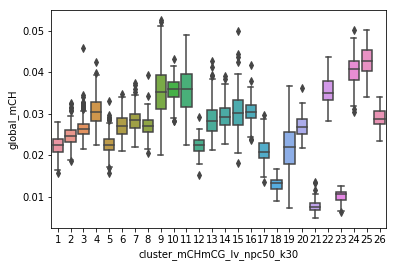

In [335]:
sns.boxplot(data=df_cells, x='cluster_mCHmCG_lv_npc50_k30', y='global_mCH')
plt.show()

In [336]:
cluster_global_mCH = df_cells.groupby('cluster_mCHmCG_lv_npc50_k30').median()['global_mCH']
cluster_nmcc = cluster_mcc.divide(cluster_global_mCH, axis=1)
cluster_nmcc.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
gene_id,,,,,,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000102693.1,0.937505,1.268105,1.265538,1.296685,0.894577,1.330883,1.100342,0.854624,1.173275,1.618389,1.450822,1.100952,0.852816,1.138755,1.205272,1.229739,1.162984,0.809989,1.089722,1.131094,1.348765,1.355945,0.759155,1.638837,0.845305,0.827341
ENSMUSG00000051951.5,0.615975,0.673944,0.685118,0.470394,0.511668,0.483953,0.516927,0.525139,0.361724,0.819773,0.361048,0.510134,0.479440,0.598619,0.678540,0.569688,0.625384,1.424569,0.633090,0.451916,1.002451,0.393786,0.700943,0.344029,0.335762,0.652881
ENSMUSG00000102851.1,0.840813,0.718820,0.622273,0.452262,0.609436,0.765566,0.507121,0.595693,0.332354,1.219350,0.339311,0.672635,0.521150,0.439753,0.784350,0.512568,0.671789,0.885985,0.744335,0.530415,1.384532,0.410654,0.852385,0.297046,0.366526,0.633292
ENSMUSG00000103377.1,0.676382,1.131408,0.797835,0.539148,0.594736,0.516549,0.639594,0.570393,0.332563,1.007584,0.298075,0.555526,0.600737,0.688843,0.682461,1.237653,0.491503,4.400577,0.924196,0.515516,1.303792,0.425001,0.788713,0.240422,0.287097,0.890700
ENSMUSG00000104017.1,0.536762,0.704314,0.713759,0.552556,0.707794,0.472904,0.714632,0.603413,0.524015,0.743622,0.394050,0.820842,0.718117,0.845123,0.916198,0.695011,0.839047,2.319528,0.646205,0.649113,0.843517,0.462512,0.807348,0.382689,0.359481,1.006678


In [337]:
# zscore by cluster, quantile by genes
data = cluster_nmcc.apply(lambda x: zscore(x, ddof=1), axis=1)
data_pct = data.rank(pct=True, axis=0)

### Succeeded in detecting the following markers: 
#### Squared sum (and cubed sum)
- L2: Enpp2
- L4: Rorb
- L6: Tle4 Syt6
- Pv: Lrrc38, Pvalb

In [338]:
### add measures to genes
df_genes['squared_sum'] = (1-data_pct).applymap(lambda x: np.power(x, 2)).sum(axis=1)
df_genes = pd.merge(df_genes, eta2.to_frame('eta_squared'), 
                    left_index=True, right_index=True, how='left')


In [340]:
markers_all = pd.DataFrame() 
tmp = pd.DataFrame()

for col in cluster_mcc.columns:
    marker_rows = 1 - data_pct[(data_pct[col] < 0.02)]
    markers = df_genes.loc[marker_rows.index, :]
    markers = markers.fillna(0)  # no effect size estimate

    ### markers rank by overall zscore
    p = 0.7
    markers['zscore_squared_sum'] = zscore(markers['squared_sum'].values)
    markers['zscore_eta_squared'] = -zscore(markers['eta_squared'].values)
    markers['overall_score'] = (p*markers['zscore_squared_sum'] + (1-p)*markers['zscore_eta_squared'])
    markers = markers.sort_values('overall_score')

    markers_all[col] = markers.head(30)['gene_name'].values
    
    
    markers['rank'] = [i+1 for i in range(len(markers))] 
#     tmp[col] = [(a, str(b)) for a, b in zip(markers_all_v2[col],
#                    markers_all_v2[col].apply(lambda x: markers.loc[markers['gene_name']==x, 'rank'].values))]
    
markers_all.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
0,Rorb,Raver2,Gm2164,Foxo1,Syt6,Pcdh15,Gm37498,Bmpr1b,Mad1l1,Tcerg1l,Lrrc38,AC160413.2,Syt6,Syt6,Adarb2,Gm26883,Adarb2,Gli3,Pax5,Syt6,Pard3b,Lhfpl3,Tacr1,Erbb4,Mad1l1,Tmem163
1,Sorcs1,Fam19a1,Stard8,Il1rapl2,Gm29730,Rorb,Gm27016,Ptpre,Npas3,BC016579,Pvalb,Syt6,Sulf1,Hs6st2,Mad1l1,Tshz2,Egfr,Abca13,Ebf2,Sulf1,Tacr1,Svil,Lhfpl3,Syt2,Npas3,Adamts3
2,Gm42450,Stard8,Fam19a1,Bmpr1b,Cyp26b1,Sorcs1,Adgra3,Sulf1,Grin3a,4933406K04Rik,Syt2,Tmem51,Gm15318,Gm37178,Npas3,Vwc2l,Cpne7,Chd7,Stard8,Nfia,Lhfpl3,Mitf,Plpp3,Lrrc38,Grin3a,Zfp804a
3,Adgrg4,Enpp2,Enpp2,Pcdh15,Gm18599,Fam19a1,A130030D18Rik,Gm27016,Reln,Myh15,Erbb4,Nfia,Xlr4d-ps,Tox,Cpne7,Abi3bp,Alk,Zfp804b,Crb1,Zfpm2,Ush2a,Inpp4b,Scn10a,Pvalb,Reln,Mreg
4,AC137117.1,Htr7,Htr7,Rorb,Zfpm2,Gm15398,Gm2694,Gm2694,Cacna2d2,Tmem163,St5,Zfpm2,Zfpm2,Cyp26b1,Kcnq4,Lcp1,Kcnq4,Gm26861,Ccdc171,Trabd2b,Ttc29,Lman1l,Skap1,St5,Paqr5,Sh3d19


In [341]:
markers_all.head(30)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
0,Rorb,Raver2,Gm2164,Foxo1,Syt6,Pcdh15,Gm37498,Bmpr1b,Mad1l1,Tcerg1l,Lrrc38,AC160413.2,Syt6,Syt6,Adarb2,Gm26883,Adarb2,Gli3,Pax5,Syt6,Pard3b,Lhfpl3,Tacr1,Erbb4,Mad1l1,Tmem163
1,Sorcs1,Fam19a1,Stard8,Il1rapl2,Gm29730,Rorb,Gm27016,Ptpre,Npas3,BC016579,Pvalb,Syt6,Sulf1,Hs6st2,Mad1l1,Tshz2,Egfr,Abca13,Ebf2,Sulf1,Tacr1,Svil,Lhfpl3,Syt2,Npas3,Adamts3
2,Gm42450,Stard8,Fam19a1,Bmpr1b,Cyp26b1,Sorcs1,Adgra3,Sulf1,Grin3a,4933406K04Rik,Syt2,Tmem51,Gm15318,Gm37178,Npas3,Vwc2l,Cpne7,Chd7,Stard8,Nfia,Lhfpl3,Mitf,Plpp3,Lrrc38,Grin3a,Zfp804a
3,Adgrg4,Enpp2,Enpp2,Pcdh15,Gm18599,Fam19a1,A130030D18Rik,Gm27016,Reln,Myh15,Erbb4,Nfia,Xlr4d-ps,Tox,Cpne7,Abi3bp,Alk,Zfp804b,Crb1,Zfpm2,Ush2a,Inpp4b,Scn10a,Pvalb,Reln,Mreg
4,AC137117.1,Htr7,Htr7,Rorb,Zfpm2,Gm15398,Gm2694,Gm2694,Cacna2d2,Tmem163,St5,Zfpm2,Zfpm2,Cyp26b1,Kcnq4,Lcp1,Kcnq4,Gm26861,Ccdc171,Trabd2b,Ttc29,Lman1l,Skap1,St5,Paqr5,Sh3d19
5,Aqp4,Igsf11,Gsg1l2,Ccdc68,Trabd2b,Pxdc1,Slamf6,Olfr1341,Paqr5,Pcsk5,Mitf,Cyp26b1,Lsp1,Hcrtr2,Vav2,Cpne4,Slc1a3,Gm12648,Begain,Lsp1,Pard3,Tmem163,Gm40999,Myo5b,Frmd4b,B3gat2
6,Gm18969,AC101709.1,2310065F04Rik,Raver2,Ephb1,Fras1,Gm13479,Slamf6,Klhl14,Rergl,Myo5b,Trabd2b,Gm34838,Elovl2,Egfem1,Fgd6,Foxo1,4933438B17Rik,Gm34719,Gm5759,Gm4593,Vwc2,Gm36736,Cacna2d2,Kif26b,Ltbp1
7,Lingo2,Igkv8-27,Ankrd6,Gm10466,Zbtb7c,Map3k21,Pdia5,Adamts3,Frmd4b,4930559C10Rik,Cacna2d2,Lsp1,Gm5759,Ephb1,Slc44a5,Rubcnl,Colec12,Lrp2,AC121978.1,Gm8401,Otx2os1,Msx3,4933438B17Rik,Mitf,C1qtnf7,Olfm3
8,Olfr209,4933415A04Rik,Ccbe1,Gm19028,Gm15331,D16Ertd472e,Adamts3,Gm13479,Eya4,Camta1,Myo6,Ephb1,Mctp1,Gm20667,Amotl1,Myzap,Egfem1,Ush2a,Gm31135,Mctp1,Gm12236,Pcsk5,Ctnna3,Myo6,Unc13c,Gm2694
9,Gm14161,Gsg1l2,Prex1,Gm15398,Cnksr3,Trbv15,Oprk1,AC154806.1,Unc13c,Gm17033,St3gal6,Etv4,Col12a1,Tle4,Htr3a,Unc13c,Fgf13,Ttc29,Gm12797,Bmp3,Mecom,Trp53i11,9530036O11Rik,St3gal6,Grm1,Cadps2


# Method 2

pros:
- one metric to get all
- great specificity

cons:
- need cell level methylation data (many genes are excluded) 
- not stable when counts are small (apply +1 shift)?
- need mean difference information 


In [347]:
# 
markers_all_v2 = pd.DataFrame() 

tmp_v2 = pd.DataFrame()

for col in cluster_mcc.columns:
    print(col, end=',')
    
    # putative markers
    marker_ids = (1 - data_pct[(data_pct[col] < 0.02)]).index

    # markers ranking by KL divergence 
    bins = np.arange(0, 3, 0.05)
    data_putative_markers = cells_nmcc.loc[marker_ids, :].dropna()

    # px
    pxs = data_putative_markers.apply(
        lambda x: (np.histogram(x, bins=bins)), axis=1).apply(
        lambda x: (x[0]+1)/((x[0]+1).sum()))

    # py
    # cells NOT in the cluster
    cells = df_cells[df_cells['cluster_'+cluster_type]!=col].index.values
    pys = data_putative_markers.loc[:, cells].apply(
        lambda x: (np.histogram(x, bins=bins)), axis=1).apply(
        lambda x: (x[0]+1)/((x[0]+1).sum()))

    # KL
    ps = pd.concat((pxs, pys), axis=1)
    kls = ps.apply(lambda x: entropy(x[0], x[1]),  axis=1)
    markers = df_genes.loc[kls.sort_values(ascending=False).index, :].copy()
    
    markers['rank'] = [i+1 for i in range(len(markers))] 
    tmp_v2[col] = [(a, str(b)) for a, b in zip(markers_all[col],
                   markers_all[col].apply(lambda x: markers.loc[markers['gene_name']==x, 'rank'].values))]
    
    markers_all_v2[col] = markers.head(30)['gene_name'].values
    

1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,

['Pvalb', 'Dock4', 'Slit2', 'Msi2', 'Ptpre', 'Fam129a', 'Robo1', 'Jak1', 'Manba', 'St3gal6', 'Fam19a2', 'Ttc39c', 'Hunk', 'Tmem132c', 'Map3k20', 'Btbd11', 'Klf12', 'Lama3', 'Syt2', 'Utrn', 'Myo1e', 'Spats2', 'Gpr176', 'Magi1', 'Creb3l2', 'Specc1', 'Blm', 'Mitf', 'Frmpd1', 'P3h2', 'Zfp704']


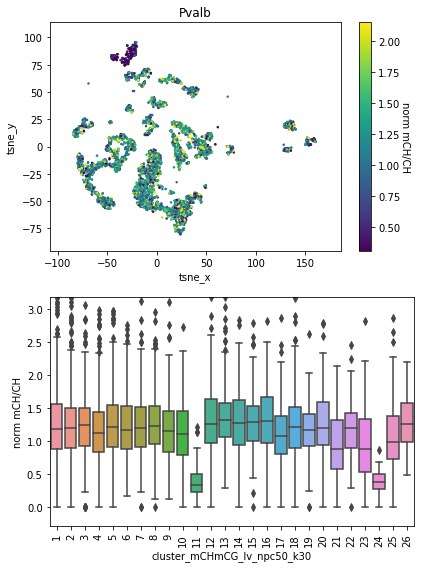

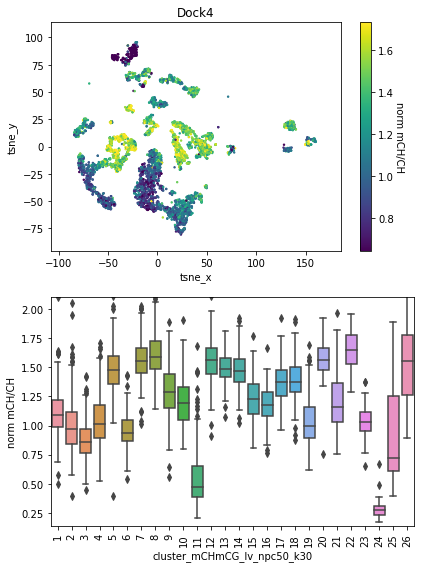

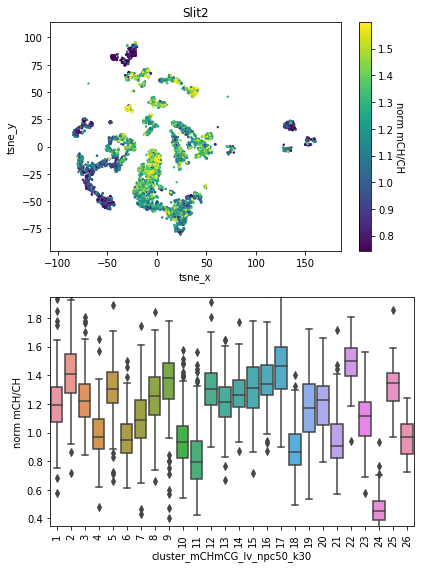

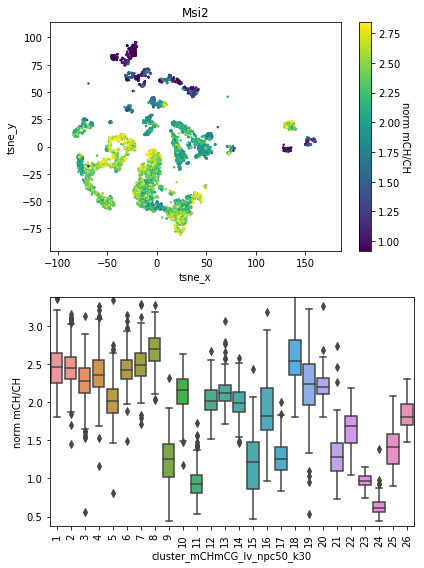

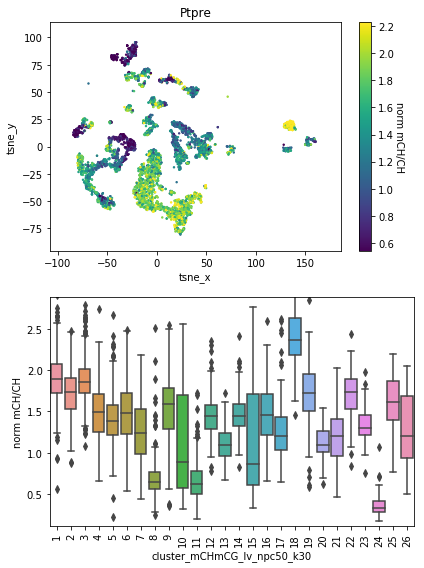

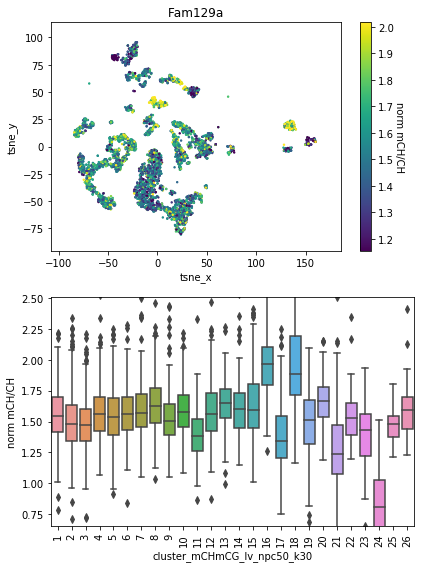

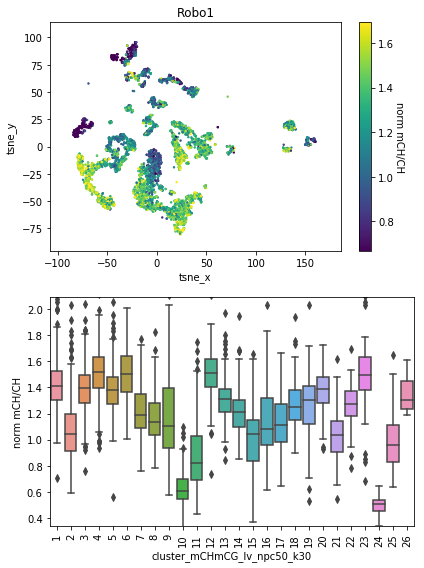

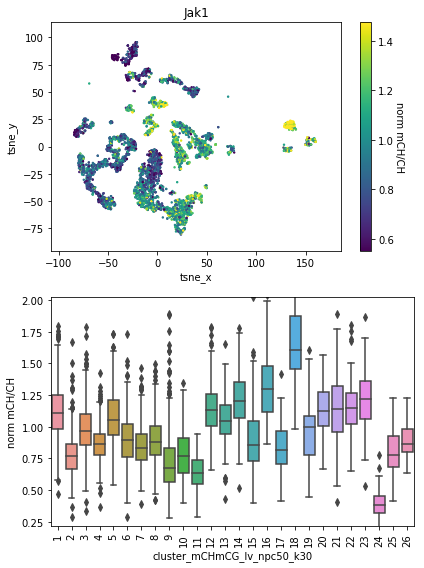

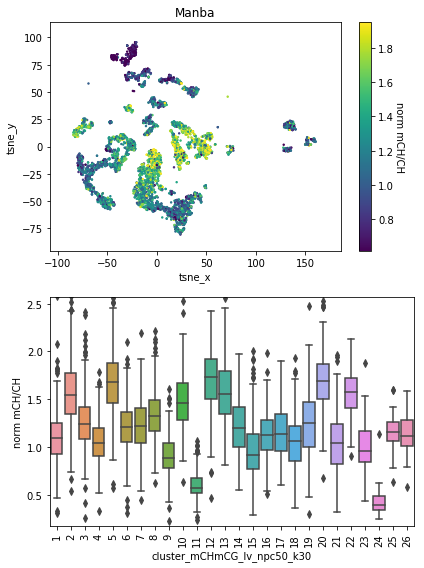

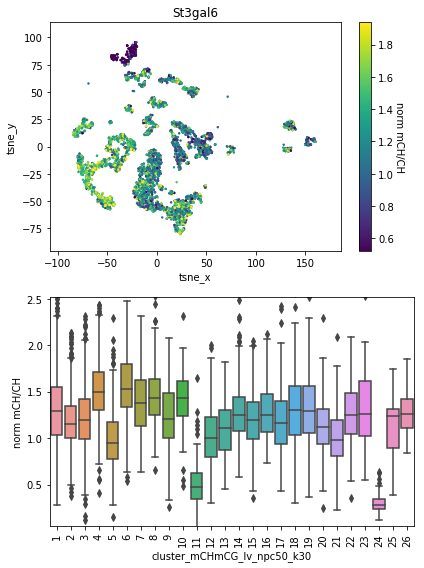

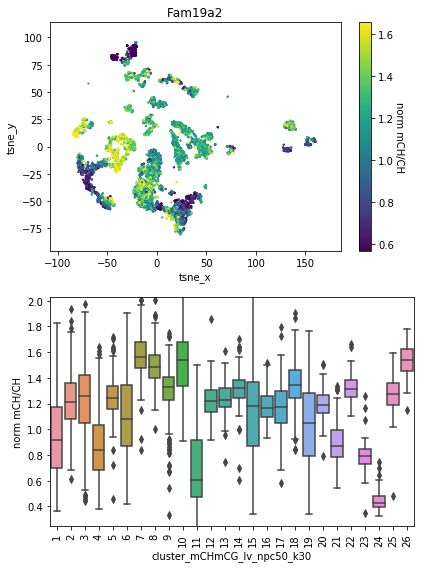

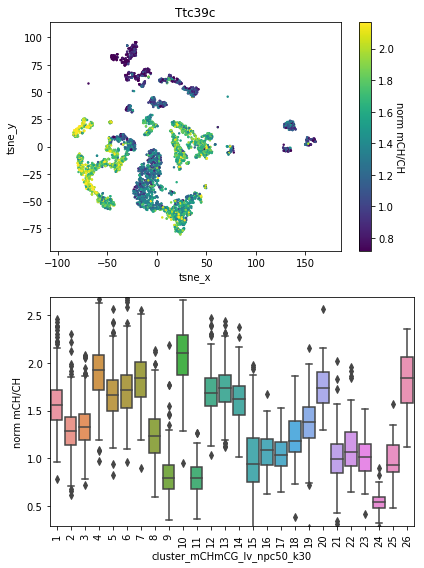

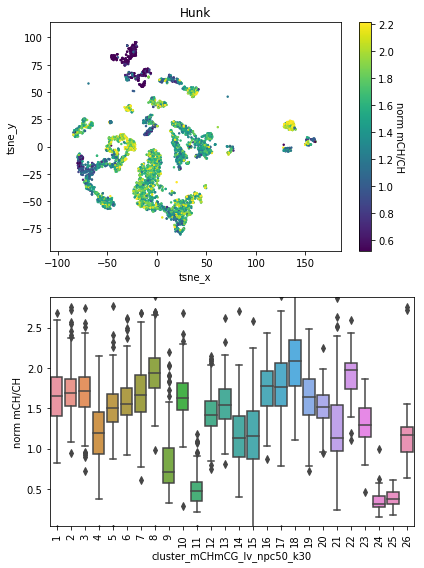

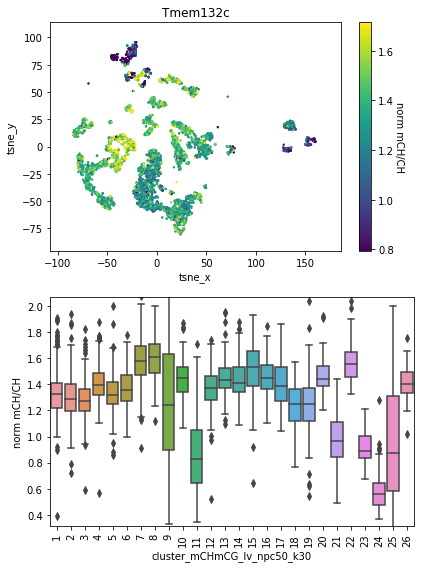

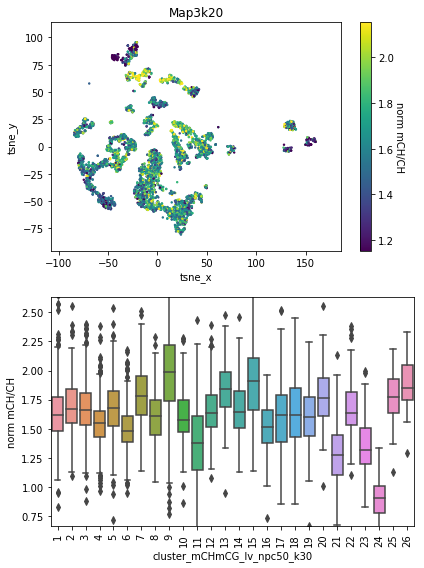

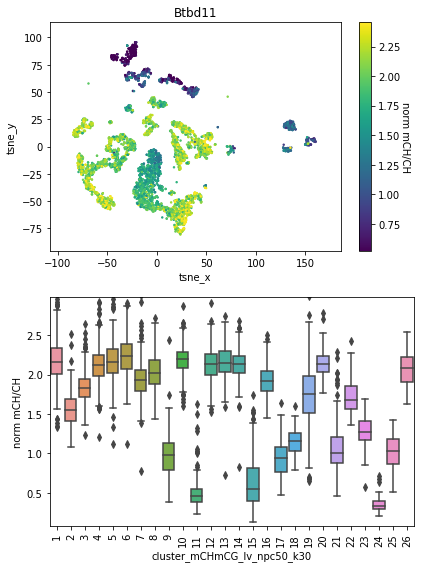

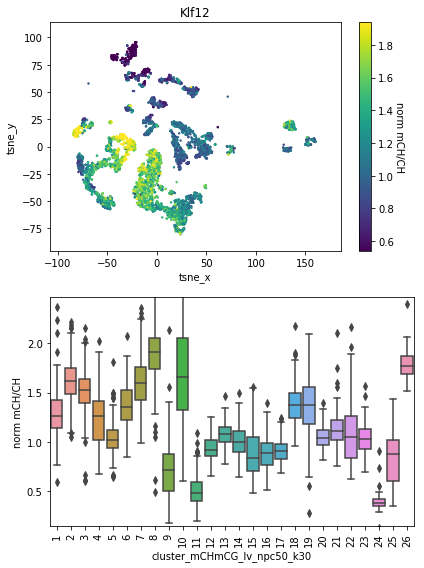

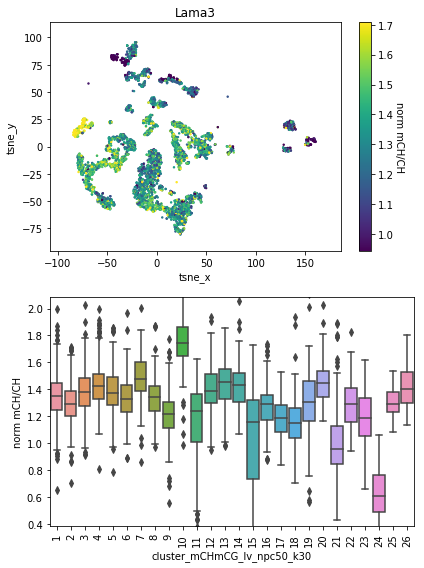

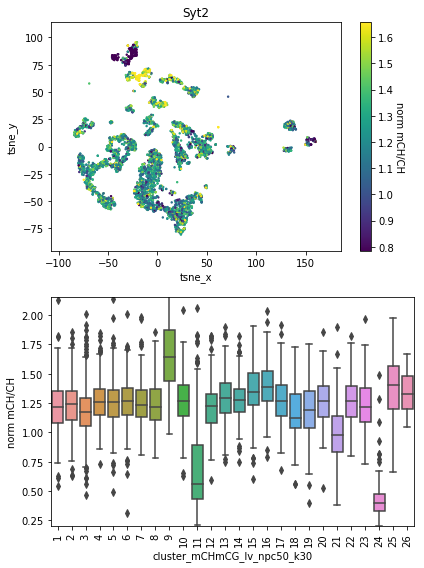

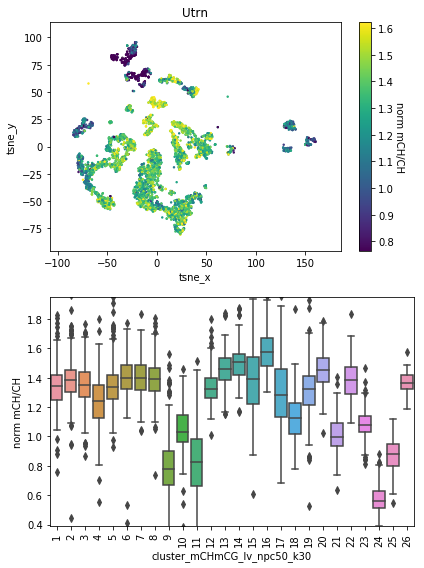

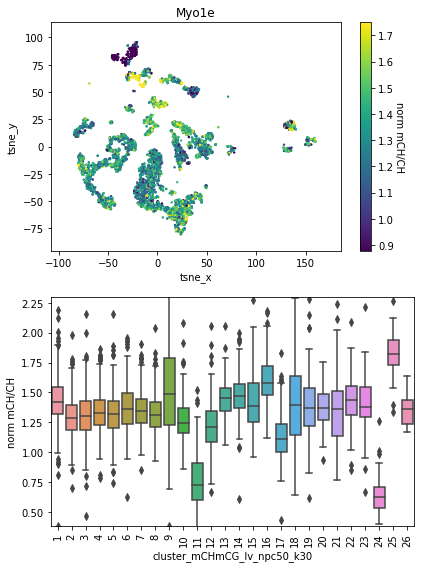

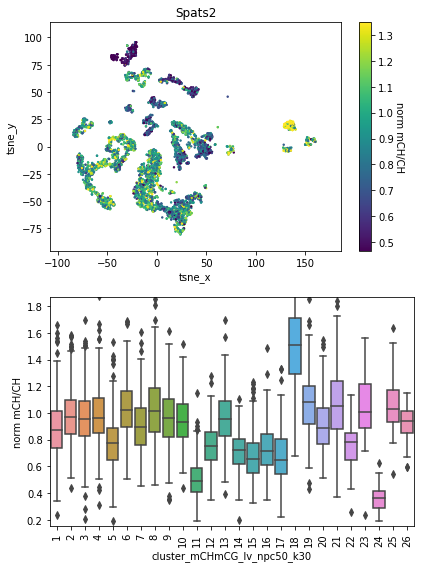

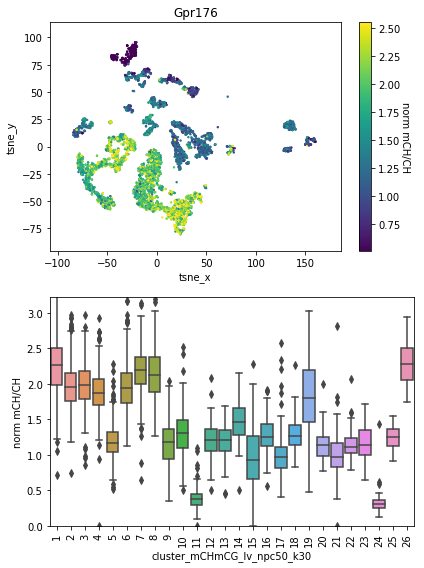

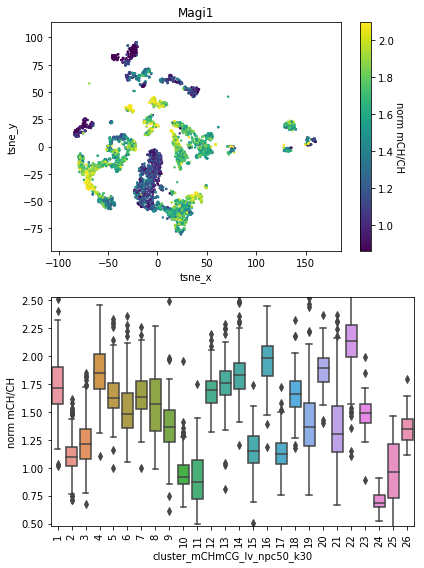

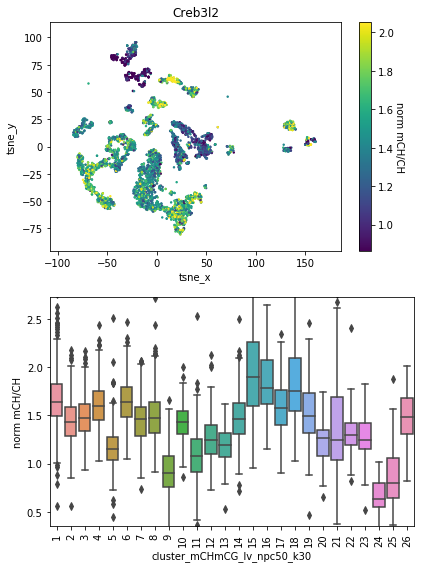

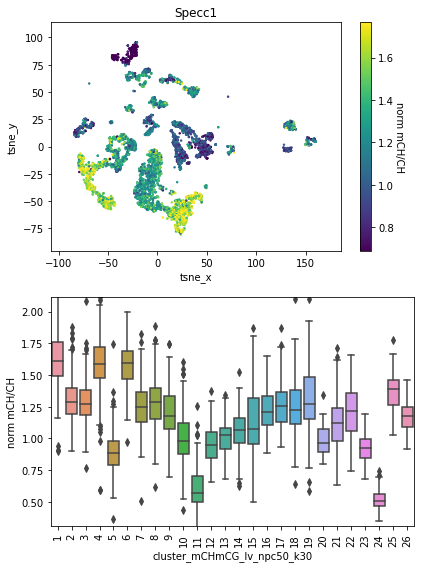

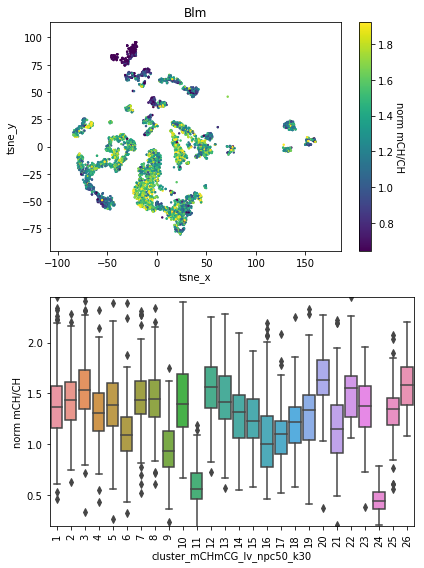

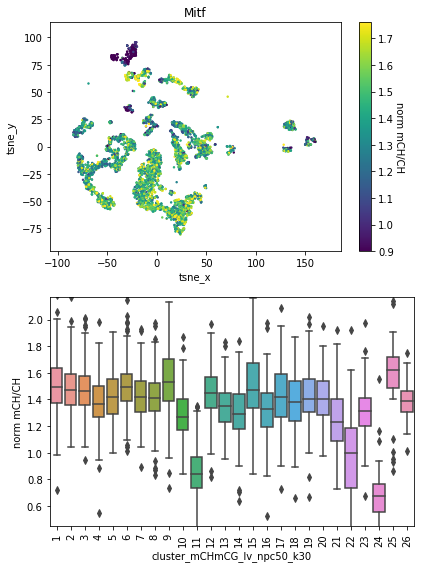

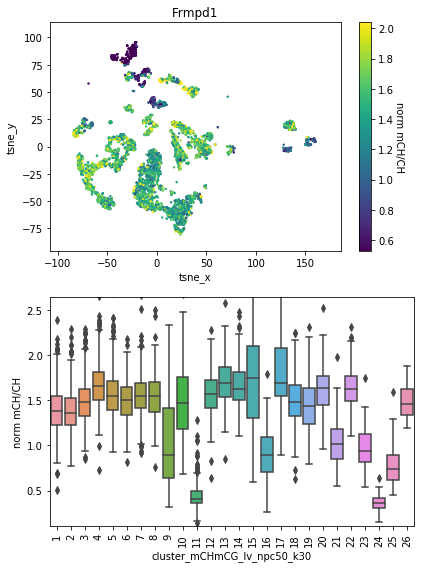

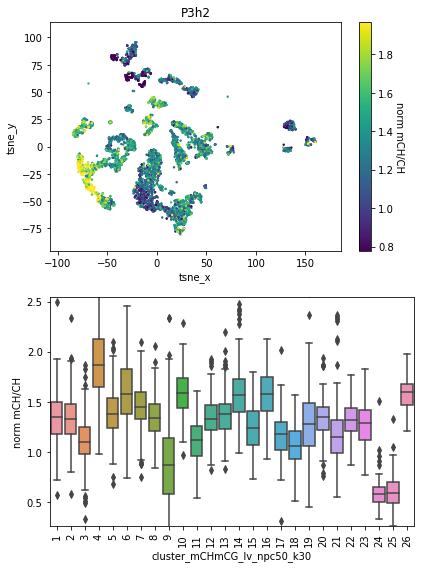

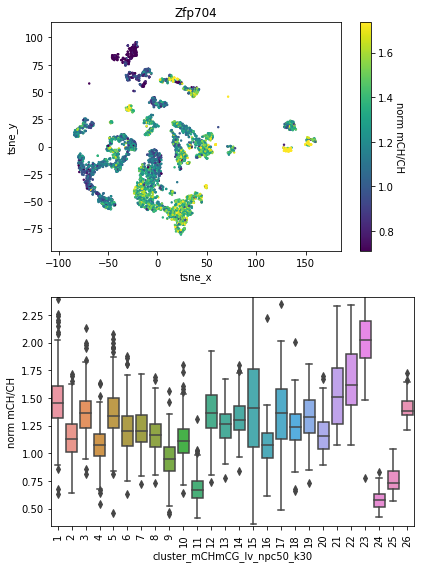

In [156]:
# visualization

engine = connect_sql(DATABASE)

# gene_names = ['Lrrc38', 'Pvalb', 'Erbb4', 'Gad1']
# gene_names = markers.head(10)['gene_name'].tolist()

gene_names = ['Raver2', 'Cux1', 'Pvalb', 'Erbb4', 'Mad1l1', 'Adarb2', 'Ptprm', 'Sox6', 'Cacna2d2']
gene_names = markers_all_v2.iloc[0, :].values
gene_names = ['Pvalb'] + markers_all_v2.loc[:, 24].tolist()
print(gene_names)


tsne_type = 'mCHmCG_ndim2_perp30'
cluster_type = 'mCHmCG_lv_npc50_k30'

gene_ids = [df_genes[df_genes['gene_name'] == gene_name].index.tolist()[0] for gene_name in gene_names] 
for gene_name, gene_id in zip(gene_names, gene_ids):
    gene_table = gene_id_to_table_name(gene_id) 
    sql = """SELECT tsne_x_{}, tsne_y_{}, cluster_{}, annotation_{}, mCH, CH, global_mCH FROM cells
    JOIN {} ON cells.cell_id = {}.cell_id
    JOIN {} ON cells.cell_id = {}.cell_id""".format(tsne_type, tsne_type, cluster_type, cluster_type, 
                                          ens, ens, 
                                         gene_table, gene_table)
    df_plot = pd.read_sql(sql, engine)
    df_plot['mCH/CH'] = df_plot['mCH']/df_plot['CH']
    df_plot['norm mCH/CH'] = df_plot['mCH/CH']/df_plot['global_mCH']
    tsne_and_boxplot(df_plot, tx='tsne_x_'+tsne_type, ty='tsne_y_'+tsne_type, tc='norm mCH/CH', 
                    bx='cluster_'+cluster_type, by='norm mCH/CH', title=gene_name)
    plt.show()
    


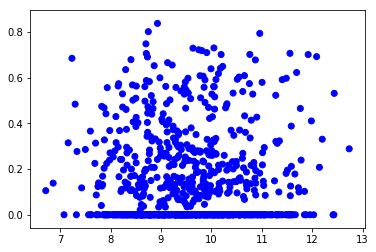

In [27]:
# # organize this bit
# # combine squared_sum and eta_squared
# marker_rows = 1 - data_pct[(data_pct['2_mcc'] < 0.02)]
# markers = df_genes.loc[marker_rows.index, :]
# markers = markers.fillna(0)  
# # markers = markers.dropna()  # remove genes with missing ANOVA values

# ### markers rank by measure1 measure2 seperately
# # markers['rank_squared_sum'] = markers['squared_sum'].rank(pct=True, axis=0)
# # markers['rank_eta_squared'] = markers['eta_squared'].rank(pct=True, axis=0, ascending=False)
# # markers['overall_score'] = (0.7*markers['rank_squared_sum'] + 0.3*markers['rank_eta_squared'])
# # markers = markers.sort_values('overall_score')

# ### markers rank by overall zscore
# p = 0.7
# markers['zscore_squared_sum'] = zscore(markers['squared_sum'].values)
# markers['zscore_eta_squared'] = -zscore(markers['eta_squared'].values)
# markers['overall_score'] = (p*markers['zscore_squared_sum'] + (1-p)*markers['zscore_eta_squared'])
# markers = markers.sort_values('overall_score')

# # plot markers on squared_sum and eta_squared
# fig, ax = plt.subplots()
# markers['color'] = ['black' if gene_name in 'Pvalb' else 'blue' for gene_name in markers['gene_name']]
# ax.scatter(markers['squared_sum'].values, markers['eta_squared'].values, c=markers['color'].values)
# plt.show()


# method 3

In [389]:
markers_all_v3= pd.DataFrame() 
tmp_v3 = pd.DataFrame()


for col in cluster_mcc.columns:
    print(col, end=',')
    p_std = 75
    
    # putative markers
    marker_ids = (1 - data_pct[(data_pct[col] < 0.05)]).index

    data_markers = cells_nmcc.loc[marker_ids, :].dropna()
    data_clst_markers = cluster_nmcc.loc[marker_ids, :].dropna()
    
    marker_ids = np.intersect1d(data_markers.index, data_clst_markers.index)
    markers = df_genes.loc[marker_ids, :].copy() 
    data_markers = cells_nmcc.loc[marker_ids, :]
    data_clst_markers = cluster_nmcc.loc[marker_ids, :]
    
    # mean dev 
    stds = data_clst_markers.std(axis=1)
    bar_std = np.percentile(stds, p_std)
    stds_masked = np.maximum(stds, bar_std)
    
    mean_dev = (data_clst_markers[col] - data_clst_markers.mean(axis=1)).divide(stds_masked, axis=0)

    # markers ranking by KL divergence 
    bins = np.arange(0, 3, 0.05)
    # px
    pxs = data_markers.apply(
        lambda x: (np.histogram(x, bins=bins)), axis=1).apply(
        lambda x: (x[0]+1)/((x[0]+1).sum()))

    # py
    # cells NOT in the cluster
    cells = df_cells[df_cells['cluster_'+cluster_type]!=col].index.values
    pys = data_markers.loc[:, cells].apply(
        lambda x: (np.histogram(x, bins=bins)), axis=1).apply(
        lambda x: (x[0]+1)/((x[0]+1).sum()))

    # KL
    ps = pd.concat((pxs, pys), axis=1)
    kls = ps.apply(lambda x: entropy(x[0], x[1]),  axis=1)
    
    
    ### markers rank by overall zscore
    markers['zscore_mean_dev'] = -zscore(mean_dev.values) # aim high 
    markers['zscore_kl'] = zscore(kls.values) # aim high
    
    p = 0.5
    markers['overall_score'] = (p*markers['zscore_mean_dev'] 
                                + (1-p)*markers['zscore_kl']
                               )
    markers = markers.sort_values('overall_score', ascending=False) # aim high
    
    markers['rank'] = [i+1 for i in range(len(markers))] 
    tmp_v3[col] = [(a, str(b)) for a, b in zip(markers_all[col],
                   markers_all[col].apply(lambda x: markers.loc[markers['gene_name']==x, 'rank'].values))]

    markers_all_v3[col] = markers.head(30)['gene_name'].values
    
    
 
    
    
    

1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,

In [390]:
markers_all_v3

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
0,Unc5d,Rgl1,Btbd9,Scube1,Foxp2,Sorcs1,2010111I01Rik,Bmp3,Dgkg,Gm30382,Adgra3,Nfia,Sema5b,Sema5a,Adarb2,Gm26883,Pde11a,Gli3,Prkg1,Nfia,Zfp521,Dlg5,Wdfy4,Dock4,Ppp4r4,Gfra1
1,Rorb,March1,Bicc1,Deptor,Dhrs3,Cdh8,Rasgef1b,Sulf1,Vcl,Ralgapa2,Chchd3,Map3k5,Adamts16,2610035D17Rik,Rxra,Tshz2,Sv2c,Gm45740,Fam172a,Zfpm2,Tanc1,Lpar1,Plpp3,Slit2,Mad1l1,Gpd2
2,Cadps2,Slit3,Prex1,Ext1,Gse1,Rora,Susd4,Bmpr1b,Grin3a,Gm2164,Nek7,Meis2,Zfpm2,Cdh18,Rgs12,Psd3,Egfr,Palld,Crb1,Sulf1,Evc2,Svil,Gm40999,Msi2,Sox6,Pdia5
3,Cdh12,Dab1,Ppfibp1,Galnt17,Susd1,Gpr158,Ntng2,Chst11,Abtb2,Fam19a1,Pde5a,Susd1,Sulf1,Tbc1d2,Dennd2a,Slit1,Kit,Gab1,Gm14005,Trabd2b,Cfap61,Kcnab1,Arhgap24,Ptpre,Frmd4b,Itpkb
4,Pde8b,Prex1,Cux2,Arhgap42,Stim2,Hs6st3,Adamts3,Slc26a4,Grm1,Ldb2,Pacsin2,Trabd2b,Foxp2,Olfml2b,Cpne2,Kremen1,Pip5k1b,Gm12153,Lingo2,Mctp1,Prdm16,Clic5,Ptpn14,Fam129a,Trhde,Ltbp1
5,Lcorl,Ccdc88c,Pdzrn3,Dgkb,Zfpm2,Susd5,Tnr,Atp2b4,Tunar,Tcerg1l,Snd1,Foxp2,Gsg1l,Rell1,Cacng4,Etv1,Fgf13,Morc1,Trpm6,Lsp1,Dock2,Inpp5a,Clnk,Robo1,Kif26b,AC137127.2
6,Lrrc4c,Hlcs,Pde7b,Raver2,Syt6,Rorb,Med27,Hrh1,CT009696.3,Nos1ap,Dock4,Cyp26b1,Grik4,Foxp2,Prox1,Rubcnl,Tgfb2,Cd82,AC124561.1,Foxp2,Wdr25,Gng12,Gm15218,Manba,Gm40438,1500009L16Rik
7,Brinp3,Rgs6,Man1c1,Pip4k2a,Ephb1,Tspan9,Npas2,Gm13479,Siah3,Sox5,Rnf144b,Syt6,Mctp1,Nrp1,Vav2,Zmiz1,Adarb2,Prr5l,Slc9a9,Arhgap25,1700057H15Rik,Hipk2,Dock1,St3gal6,Fnip2,Car3
8,Kcnh5,Prkca,Enpp2,Ptgfrn,Rgma,Plxnd1,Chrm2,Csgalnact1,Ifit1bl1,Crim1,Xxylt1,Emid1,Slc1a7,Syt6,Sorcs3,Lcp1,Alk,Gm26861,Casz1,Thsd7b,Zfp423,Galnt10,AC093022.4,Jak1,Elfn1,Col11a1
9,Tspan11,Glis3,Cdh6,Clstn2,Rnf152,Kcnh5,Csgalnact1,Ak5,Frmd4b,Ctbp2,Ntn4,Dhrs3,Hs3st4,Slit1,Nr3c2,Hip1,Ltbp2,Abca13,Nek10,Sla,Bnc2,Inpp4b,Lhfpl3,Fam19a2,Reln,B3gat2


In [391]:
tmp_v3

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
0,"(Rorb, [2])","(Raver2, [133])","(Gm2164, [19])","(Foxo1, [12])","(Syt6, [7])","(Pcdh15, [27])","(Gm37498, [])","(Bmpr1b, [3])","(Mad1l1, [17])","(Tcerg1l, [6])","(Lrrc38, [145])","(AC160413.2, [])","(Syt6, [14])","(Syt6, [9])","(Adarb2, [1])","(Gm26883, [1])","(Adarb2, [8])","(Gli3, [1])","(Pax5, [12])","(Syt6, [18])","(Pard3b, [57])","(Lhfpl3, [106])","(Tacr1, [39])","(Erbb4, [66])","(Mad1l1, [2])","(Tmem163, [33])"
1,"(Sorcs1, [13])","(Fam19a1, [18])","(Stard8, [35])","(Il1rapl2, [30])","(Gm29730, [])","(Rorb, [7])","(Gm27016, [35])","(Ptpre, [11])","(Npas3, [19])","(BC016579, [113])","(Pvalb, [63])","(Syt6, [8])","(Sulf1, [4])","(Hs6st2, [50])","(Mad1l1, [43])","(Tshz2, [2])","(Egfr, [3])","(Abca13, [10])","(Ebf2, [22])","(Sulf1, [3])","(Tacr1, [60])","(Svil, [3])","(Lhfpl3, [10])","(Syt2, [11])","(Npas3, [65])","(Adamts3, [49])"
2,"(Gm42450, [])","(Stard8, [198])","(Fam19a1, [70])","(Bmpr1b, [95])","(Cyp26b1, [26])","(Sorcs1, [1])","(Adgra3, [72])","(Sulf1, [2])","(Grin3a, [3])","(4933406K04Rik, [88])","(Syt2, [65])","(Tmem51, [219])","(Gm15318, [676])","(Gm37178, [])","(Npas3, [22])","(Vwc2l, [62])","(Cpne7, [27])","(Chd7, [11])","(Stard8, [47])","(Nfia, [1])","(Lhfpl3, [23])","(Mitf, [108])","(Plpp3, [2])","(Lrrc38, [108])","(Grin3a, [29])","(Zfp804a, [57])"
3,"(Adgrg4, [265])","(Enpp2, [51])","(Enpp2, [9])","(Pcdh15, [89])","(Gm18599, [])","(Fam19a1, [74])","(A130030D18Rik, [143])","(Gm27016, [75])","(Reln, [37])","(Myh15, [350])","(Erbb4, [27])","(Nfia, [1])","(Xlr4d-ps, [])","(Tox, [42])","(Cpne7, [19])","(Abi3bp, [165])","(Alk, [9])","(Zfp804b, [21])","(Crb1, [3])","(Zfpm2, [2])","(Ush2a, [69])","(Inpp4b, [10])","(Scn10a, [25])","(Pvalb, [77])","(Reln, [10])","(Mreg, [72])"
4,"(AC137117.1, [759])","(Htr7, [419])","(Htr7, [404])","(Rorb, [186])","(Zfpm2, [6])","(Gm15398, [41])","(Gm2694, [12])","(Gm2694, [64])","(Cacna2d2, [21])","(Tmem163, [25])","(St5, [14])","(Zfpm2, [15])","(Zfpm2, [3])","(Cyp26b1, [16])","(Kcnq4, [21])","(Lcp1, [9])","(Kcnq4, [24])","(Gm26861, [9])","(Ccdc171, [15])","(Trabd2b, [4])","(Ttc29, [40])","(Lman1l, [36])","(Skap1, [45])","(St5, [49])","(Paqr5, [15])","(Sh3d19, [44])"
5,"(Aqp4, [203])","(Igsf11, [12])","(Gsg1l2, [325])","(Ccdc68, [342])","(Trabd2b, [32])","(Pxdc1, [125])","(Slamf6, [481])","(Olfr1341, [291])","(Paqr5, [46])","(Pcsk5, [128])","(Mitf, [74])","(Cyp26b1, [7])","(Lsp1, [36])","(Hcrtr2, [17])","(Vav2, [8])","(Cpne4, [64])","(Slc1a3, [40])","(Gm12648, [22])","(Begain, [119])","(Lsp1, [6])","(Pard3, [15])","(Tmem163, [20])","(Gm40999, [3])","(Myo5b, [83])","(Frmd4b, [4])","(B3gat2, [10])"
6,"(Gm18969, [])","(AC101709.1, [364])","(2310065F04Rik, [126])","(Raver2, [7])","(Ephb1, [8])","(Fras1, [119])","(Gm13479, [123])","(Slamf6, [318])","(Klhl14, [345])","(Rergl, [205])","(Myo5b, [18])","(Trabd2b, [5])","(Gm34838, [567])","(Elovl2, [64])","(Egfem1, [70])","(Fgd6, [32])","(Foxo1, [103])","(4933438B17Rik, [136])","(Gm34719, [236])","(Gm5759, [])","(Gm4593, [496])","(Vwc2, [93])","(Gm36736, [20])","(Cacna2d2, [98])","(Kif26b, [6])","(Ltbp1, [5])"
7,"(Lingo2, [21])","(Igkv8-27, [])","(Ankrd6, [413])","(Gm10466, [83])","(Zbtb7c, [38])","(Map3k21, [435])","(Pdia5, [18])","(Adamts3, [23])","(Frmd4b, [10])","(4930559C10Rik, [702])","(Cacna2d2, [26])","(Lsp1, [23])","(Gm5759, [])","(Ephb1, [31])","(Slc44a5, [13])","(Rubcnl, [7])","(Colec12, [95])","(Lrp2, [102])","(AC121978.1, [])","(Gm8401, [])","(Otx2os1, [63])","(Msx3, [])","(4933438B17Rik, [49])","(Mitf, [28])","(C1qtnf7, [19])","(Olfm3, [36])"
8,"(Olfr209, [])","(4933415A04Rik, [])","(Ccbe1, [34])","(Gm19028, [])","(Gm15331, [])","(D16Ertd472e, [15])","(Adamts3, [5])","(Gm13479, [8])","(Eya4, [202])","(Camta1, [154])","(Myo6, [300])","(Ephb1, [16])","(Mctp1, [8])","(Gm20667, [])","(Amotl1, [31])","(Myzap, [11])","(Egfem1, [109])","(Ush2a, [25])","(Gm31135, [39])","(Mctp1, [5])","(Gm12236, [56])","(Pcsk5, [14])","(Ctnna3, [64])","(Myo6, [219])","(Unc13c, [18])",

In [392]:
markers_all.head(30)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
0,Rorb,Raver2,Gm2164,Foxo1,Syt6,Pcdh15,Gm37498,Bmpr1b,Mad1l1,Tcerg1l,Lrrc38,AC160413.2,Syt6,Syt6,Adarb2,Gm26883,Adarb2,Gli3,Pax5,Syt6,Pard3b,Lhfpl3,Tacr1,Erbb4,Mad1l1,Tmem163
1,Sorcs1,Fam19a1,Stard8,Il1rapl2,Gm29730,Rorb,Gm27016,Ptpre,Npas3,BC016579,Pvalb,Syt6,Sulf1,Hs6st2,Mad1l1,Tshz2,Egfr,Abca13,Ebf2,Sulf1,Tacr1,Svil,Lhfpl3,Syt2,Npas3,Adamts3
2,Gm42450,Stard8,Fam19a1,Bmpr1b,Cyp26b1,Sorcs1,Adgra3,Sulf1,Grin3a,4933406K04Rik,Syt2,Tmem51,Gm15318,Gm37178,Npas3,Vwc2l,Cpne7,Chd7,Stard8,Nfia,Lhfpl3,Mitf,Plpp3,Lrrc38,Grin3a,Zfp804a
3,Adgrg4,Enpp2,Enpp2,Pcdh15,Gm18599,Fam19a1,A130030D18Rik,Gm27016,Reln,Myh15,Erbb4,Nfia,Xlr4d-ps,Tox,Cpne7,Abi3bp,Alk,Zfp804b,Crb1,Zfpm2,Ush2a,Inpp4b,Scn10a,Pvalb,Reln,Mreg
4,AC137117.1,Htr7,Htr7,Rorb,Zfpm2,Gm15398,Gm2694,Gm2694,Cacna2d2,Tmem163,St5,Zfpm2,Zfpm2,Cyp26b1,Kcnq4,Lcp1,Kcnq4,Gm26861,Ccdc171,Trabd2b,Ttc29,Lman1l,Skap1,St5,Paqr5,Sh3d19
5,Aqp4,Igsf11,Gsg1l2,Ccdc68,Trabd2b,Pxdc1,Slamf6,Olfr1341,Paqr5,Pcsk5,Mitf,Cyp26b1,Lsp1,Hcrtr2,Vav2,Cpne4,Slc1a3,Gm12648,Begain,Lsp1,Pard3,Tmem163,Gm40999,Myo5b,Frmd4b,B3gat2
6,Gm18969,AC101709.1,2310065F04Rik,Raver2,Ephb1,Fras1,Gm13479,Slamf6,Klhl14,Rergl,Myo5b,Trabd2b,Gm34838,Elovl2,Egfem1,Fgd6,Foxo1,4933438B17Rik,Gm34719,Gm5759,Gm4593,Vwc2,Gm36736,Cacna2d2,Kif26b,Ltbp1
7,Lingo2,Igkv8-27,Ankrd6,Gm10466,Zbtb7c,Map3k21,Pdia5,Adamts3,Frmd4b,4930559C10Rik,Cacna2d2,Lsp1,Gm5759,Ephb1,Slc44a5,Rubcnl,Colec12,Lrp2,AC121978.1,Gm8401,Otx2os1,Msx3,4933438B17Rik,Mitf,C1qtnf7,Olfm3
8,Olfr209,4933415A04Rik,Ccbe1,Gm19028,Gm15331,D16Ertd472e,Adamts3,Gm13479,Eya4,Camta1,Myo6,Ephb1,Mctp1,Gm20667,Amotl1,Myzap,Egfem1,Ush2a,Gm31135,Mctp1,Gm12236,Pcsk5,Ctnna3,Myo6,Unc13c,Gm2694
9,Gm14161,Gsg1l2,Prex1,Gm15398,Cnksr3,Trbv15,Oprk1,AC154806.1,Unc13c,Gm17033,St3gal6,Etv4,Col12a1,Tle4,Htr3a,Unc13c,Fgf13,Ttc29,Gm12797,Bmp3,Mecom,Trp53i11,9530036O11Rik,St3gal6,Grm1,Cadps2


In [393]:
for i, (col1, col2) in enumerate(zip(markers_all_v3.columns, markers_all.columns)):
    x = np.intersect1d(markers_all[col2], markers_all_v3[col1])
    print(i+1, len(x))

1 7
2 7
3 9
4 8
5 12
6 8
7 7
8 9
9 13
10 9
11 12
12 14
13 11
14 12
15 14
16 12
17 12
18 12
19 5
20 12
21 6
22 10
23 12
24 8
25 12
26 13


In [ ]:
# wrap up
def detect_marker_genes(cells_nmcc, clusters_nmcc, df_cells, df_genes, 
                        ntop=30, p_std=0.75, p = 0.5, p_putative=0.05, bins=np.arange(0, 3, 0.05)):
    """Given cluster assignment, gene annotation and data matrix, 
    compute top marker genes for each cluster.
    Metrics: KL divergence and difference in mean/std
    
    This could in principle be extended to compute any "marker features", but coverage might be an issue 
    for short genomic region as it requires the feature to have good coverage at cell level.
    
    Args:
        - cells_nmcc matrix: 
            A dataframe of nmcc values of gene by cell matrix 
        
        - clusterss_nmcc matrix: 
            A dataframe of nmcc values of gene by cluster matrix 
        
        - df_cells: cluster assignment of cells 
            A dataframe with cell name as index and cluster assignment as a column.
            
        - df_genes: gene_annotation 
            A dataframe with gene_id as index and gene_name as a column.
        
        - ntop: default 30
            number of top marker genes
        - p_std: default 0.75
            threshold percentile of standard deviation above which mean difference is penalized 
        - p: default 0.5
            fraction of mean_dev (overall score = p*mean_dev + (1-p)*kl_divergence)
        - p_putative: default 0.05
            fraction of genes go into further consideration
        - bins: default = np.arange(0, 3, 0.05)
            bins used for kl divergence calculation
            
        
    
    Return:
        - A dataframe of top marker genes for each cluster/column
    """

    markers_all = pd.DataFrame() 

    for col in clusters_mcc.columns:
        print(col, end=',')

        # putative markers
        marker_ids = (1 - data_pct[(data_pct[col] < p_putative)]).index

        data_markers = cells_nmcc.loc[marker_ids, :].dropna()
        data_clst_markers = cluster_nmcc.loc[marker_ids, :].dropna()

        marker_ids = np.intersect1d(data_markers.index, data_clst_markers.index)
        markers = df_genes.loc[marker_ids, :].copy() 
        data_markers = cells_nmcc.loc[marker_ids, :]
        data_clst_markers = cluster_nmcc.loc[marker_ids, :]

        # mean dev 
        stds = data_clst_markers.std(axis=1)
        bar_std = np.percentile(stds, 100*p_std)
        stds_masked = np.maximum(stds, bar_std)

        mean_dev = (data_clst_markers[col] - data_clst_markers.mean(axis=1)).divide(stds_masked, axis=0)

        # markers ranking by KL divergence 
        # px
        pxs = data_markers.apply(
            lambda x: (np.histogram(x, bins=bins)), axis=1).apply(
            lambda x: (x[0]+1)/((x[0]+1).sum()))

        # py
        # cells NOT in the cluster
        cells = df_cells[df_cells['cluster_'+cluster_type]!=col].index.values
        pys = data_markers.loc[:, cells].apply(
            lambda x: (np.histogram(x, bins=bins)), axis=1).apply(
            lambda x: (x[0]+1)/((x[0]+1).sum()))

        # KL
        ps = pd.concat((pxs, pys), axis=1)
        kls = ps.apply(lambda x: entropy(x[0], x[1]),  axis=1)


        ### markers rank by overall zscore
        markers['zscore_mean_dev'] = -zscore(mean_dev.values) # aim high 
        markers['zscore_kl'] = zscore(kls.values) # aim high

        markers['overall_score'] = (p*markers['zscore_mean_dev'] 
                                    + (1-p)*markers['zscore_kl']
                                   )
        markers = markers.sort_values('overall_score', ascending=False) # aim high
        markers_all[col] = markers.head(ntop)['gene_name'].values
    
    print('\n done.')
    return markers_all